# Week 1 - Linear Regression with a (Stochastic) Gradient Descent

Welcome to your first programming assignment! 
Today you will build a linear regression model with different algorithms: inversion-based and stochastic gradient descent. 
You're probably familiar with the first algorithm, as it is the most commonly used one for linear regression.
However, the second one, stochastic gradient descent, will become an important building block for models more complex than linear regression.
So in a sense, today you're making your first step towards building a neural network.

**Instructions:**

_code exercises:_

- Cells in which you must write code start with #Exercise:
- Write code within the blocks denotes with ### START CODE HERE ### and ### END CODE HERE ###
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

_text exercises:_
- Cells in which you must write text start with @Exercise:
- Write text within the blocks denotes with @@@ START MARKDOWN HERE @@@ and @@@ END CODE HERE @@@
- Learn more about the markdown syntax [here](https://daringfireball.net/projects/markdown/syntax)
- Latex style math equations can be written between double dollar signs e.g.  \$\$ e=mc^2 \$\$ gives $$ e=mc^2, $$ and inline math can be written inbetween single dollar signs \$ math here \$.
- Learn more about the math latex syntax [here](http://reu.dimacs.rutgers.edu/Symbols.pdf)

# Packages

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [scikit-learn](http://scikit-learn.org/stable/index.html) is machine learning package for python
- [time](https://docs.python.org/3/library/time.html) is a core package of python for time related functionality
- [random](https://docs.python.org/3/library/random.html) is a core package of python from random related functionality



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import numpy as np # math functions
import time # timing functions
import random # sampling functions
from sklearn.metrics import r2_score

In [2]:
# custom function to print colored markdown, for instructional purposes
from IPython.display import Markdown, display
def printmd(string, color=None):
    colorstr = f"<span style='color:{color}'>{string}</span>"
    display(Markdown(colorstr))

printmd("**test markdown print: bold and blue**", color="blue")

<span style='color:blue'>**test markdown print: bold and blue**</span>

# Data

Let us first create a dataset. Complete the function below such that we obtain:

* vectors $\mathbf{x, t}$ of length $N$
* where x is in range (0,10)
* where $t=2+1.25x + 4 \sin(4x) + \varepsilon$ 
* where $\varepsilon \sim N(0,\sigma)$

In [3]:
#Exercise: Create a dataset generator function
def generate_dataset(n,sigma):
    """
    Purpose:
        Generate a dataset of length n, where:
               explanatory data x is linearly spaced in range of 0, 10 
               target data t = 2 + 1.25x + 4*sin(4*x) + noise
    Inputs:
        n     integer, length of the dataset
        sigma double, standard deviation of noise
    Output:
        x     (n,) vector, explanatory data
        t     (n,) vector, target data
    """
    ### START CODE HERE ###
    x = np.linspace(0,10,n)
    t = 2 + 1.25*x + 4*np.sin(4*x) + np.random.randn(n)*sigma
    ### END CODE HERE ###
    return x, t


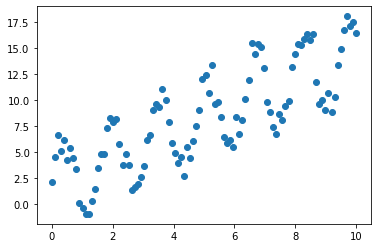

In [4]:
n_ex = 100
sigma_ex = 1
x_ex, t_ex = generate_dataset(n_ex,sigma_ex)

# plot
plt.scatter(x_ex,t_ex)
plt.show()

# Loss function

Given: 

$\mathbf{t}$ -- target variable, a vector of length n

$\mathbf{x}$ -- predictor variable, a vector of length n

It is our goal to create a model which can predict t given x:

$\mathbf{y}$ -- our predicted value, a vector of length n

We define our performance at this task with a loss function:

$E$ -- the loss/error in using $y$ instead of $t$

$$E(y,t) = \frac{1}{2n} \sum_{i=1}^{n} (t_i - y_i)^2$$

In [5]:
#Exercise: create a loss function
def square_loss(t,y):
    """
    Purpose:
        Calculate loss function
    Inputs:
        t     (n,) vector, target variable
        y     (n,) vector, predicted values
    Output:
        loss  double, loss value
    """
    ### START CODE HERE ###
    loss = 0.5*np.mean((t-y)**2)
    ### END CODE HERE ###
    return loss

# Feature Engineering

Given that there is a clear non-linear relationship between x and t, but we are constrained by making a linear model, we must start with creating some features.
While you're probably already familiar with polynomial features (e.g. $x^2$), another useful transformation are gaussian basis functions (see chapter 3.1 of Bishop).
Let's engineer some features  based on gaussian basis transformations.

In [6]:
#Exercise: create the gassian basis function:
def gaussian_basis_function(x,mean,scale):
    """
    Purpose:
        Create the Gaussian basis function transformation, see equation 3.4 of Bishop
    Inputs:
        x     (n,) vector
        mean  double, location parameter
        scale double, scale parameter
    Output:
        gbf   (n,) vector, transformed values
    """
    ### START CODE HERE ###
    gbf = np.exp(-(x-mean)**2/(2*scale**2))
    ### END CODE HERE ###
    return gbf

In [7]:
#Exercise: create a gaussian basis transformation function
def gaussian_basis_transformation(x,k,scale='auto'):
    """
    Purpose:
        Create features based on multiple gaussian basis functions such that:
            Automatically set the means of Gaussian functions to be linearly spaced in the range of input x
            Standard deviation can be manually supplied, or set to 'auto'
    Inputs:
        x      (n,) vector, explanatory variable
        k      integer, number of transformations
        scale  double, scale parameter:
                      if set 'auto' (default), then it equals difference between means
    Output:
        gbt    (n,k) matrix, transformed values
    """
    ### START CODE HERE ###
    means = np.linspace(np.min(x), np.max(x),k)
    if scale == 'auto':
        scale = means[1] - means[0]
        
    gbt = np.array([gaussian_basis_function(x,i,scale) for i in means])
    gbt = gbt.T
    ### END CODE HERE ###

    return gbt

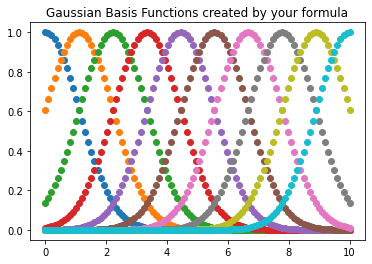

In [8]:
# expected output
k = 10
gbt = gaussian_basis_transformation(x_ex,k)
for c in range(k):
    plt.scatter(x_ex,gbt[:,c])
plt.title('Gaussian Basis Functions created by your formula')
plt.show()


In [9]:
printmd('**Check your own result, compare to the image below:**','red')

<span style='color:red'>**Check your own result, compare to the image below:**</span>

![gbf expeced output](https://www.cjbs.net/users/yihe/storage/mle/gbf_expected_output.png)

We can then create *design matrix* $\mathbf{\Phi}$ by adding a vector of ones, and our original feature vector x to the gaussian basis transformations

In [10]:
phi = np.column_stack((np.ones(x_ex.shape[0]), x_ex, gbt))

# Model

Suppose we want to create a linear model.

$$\mathbf{y} = \mathbf{\Phi(x)w}$$

Where $\mathbf{(\Phi(x)}$ is a matrix of features based on our explanatory variables $\mathbf{x}$, and where $\mathbf{w}$ are a vector of weights (usually denoted with $\mathbf{\beta}$ in econometrics books).

In [11]:
#Exercise: create a predict function
def lr_predict(phi, w):
    """
    Purpose:
        Calculate predicted values
    Inputs:
        phi   (n,k) matrix, design matrix
        w     (k,) vector, weights
    Output:
        y     (n,) vector, predicted values
    """
    ### START CODE HERE ###
    y = phi @w
    ### END CODE HERE ###
    return y

# Maximum Likelihood Approach

## Intuition

From your basic econometrics course you will remember that it can be proven that the parameters which minimize the square loss function is:

$$ \mathbf{w = (\Phi^T \Phi)^{-1}\Phi^Tt}$$

## Create method

In [12]:
#Exercise: create the inverse based method for linear regression
def lr(phi,t):
    """
    Purpose:
        Linear regression based on matrix inversion
    Inputs:
        phi   (n,k) matrix, design matrix
        t     (n,) vector, target variable
    Output:
        w     (k,) vector, weights
    """
    ### START CODE HERE ###
    w = np.linalg.inv(phi.T @ phi) @ (phi.T @ t)
    ### END CODE HERE ###
    return w

## Example

### Simple linear regression

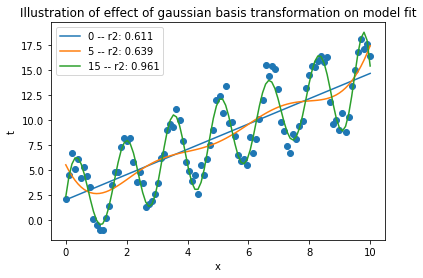

In [13]:
# Exercise: Create a scatter plot with:
# * The original data as a scatter plot
# * The fitted lines of a linear regression model with 0, 5, and 15 basis functions

### START CODE HERE ###
# you can loop through the numbers of gaussian basis transformations
for i in [0,5,15]:
    if i > 0:
        gbt = gaussian_basis_transformation(x_ex,i)
        phi = np.column_stack((np.ones(x_ex.shape[0]), x_ex, gbt))
    else:
        phi = np.column_stack((np.ones(x_ex.shape[0]), x_ex))
        
    w = lr(phi,t_ex)
    y = lr_predict(phi,w)
    r2 = r2_score(t_ex,y)
    plt.plot(x_ex,y,label=f'{i} -- r2: {r2:.3f}')

# plot
plt.scatter(x_ex,t_ex,)
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Illustration of effect of gaussian basis transformation on model fit')
plt.show()
### END CODE HERE ###

In [14]:
# we see that 15 basis functions work quite well, lets continue with that for now
gbt = gaussian_basis_transformation(x_ex,15)
phi_ex = np.column_stack((np.ones(x_ex.shape[0]), x_ex, gbt))

# Gradient Descent Based Approach

## Issues with the inversion based approach

The direct/inversion based approach has multiple limitations (Bishop 3.1.3):

* It does not scale well when the number of features increase
* It is not suitable for some practical applications, where the data arrives sequentially (e.g. twitter text)
* It does not work for models which non-linear models which we will see later in the course

As an alternative we can use a stepwise approach called *gradient descent*.

![gradient descent illustration](https://www.cjbs.net/users/yihe/storage/mle/Gradient_Descent_Visualized_web.png)
*img credits: chrisalbon.com*

Algorithm:

1. Define a model
2. Initialize the parameters
3. Predict
4. Calculate the loss
5. Calculate the gradient of the loss with respect to the parameters
6. Update the parameters
7. If parameterse converged then stop else goto 3



## Create method

In [15]:
printmd("**Markdown exercise below: calculate the gradient for the loss function wrt the parameters**", "red")

<span style='color:red'>**Markdown exercise below: calculate the gradient for the loss function wrt the parameters**</span>

**@Exercise: Derive the gradient**
Use the chain rule to calculate the gradient for the loss function: $ \frac{\partial E}{\partial \mathbf{w}} = \ldots$

*@@@ START MARKDOWN ANSWER HERE @@@*

Chain rule gives:

$$ \frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{w}} $$

and 

$$ \frac{\partial E}{\partial \mathbf{y}} = \frac{\partial \frac{1}{2n} \sum_{i=1}^n (t_i-y_i)^2}{\partial \mathbf{y}}  = -\frac{1}{n} (\mathbf{t-y})$$

$$ \frac{\partial \mathbf{y}}{\partial \mathbf{w}} = \frac{\partial \mathbf{\Phi w}}{\partial \mathbf{w}} = \mathbf{\Phi}$$

therefore

$$ \frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{w}}  = -\frac{1}{n} (\mathbf{t-y})^T \mathbf{\Phi}$$

*@@@ END MARKDOWN ANSWER HERE @@@*


In [16]:
#Exercise: create the gradient function
def lr_gradient(phi,t,y):
    """
    Purpose:
        Calculate gradient function of the loss function
    Inputs:
        phi   (n,k) matrix, design matrix
        t     (n,) vector, target variable
        y     (n,) vector, predicted values
    Output:
        dEdw  double, gradient value
    """
    ### START CODE HERE ###
    n = phi.shape[0]
    dEdw = -1/n*(t-y).T@phi
    ### END CODE HERE ###
    
    return dEdw

In [17]:
#Exercise: gradient descent based parameter estimation
def lr_gd(phi,t,eta, epochs,verbose=False):
    """
    Purpose:
        Optimizer function for the gradient descent algorithm
            keep updating the parameters w for a given number of epochs
    Inputs:
        phi    (n,k) matrix, design matrix
        t      (n,) vector, target variable
        eta    double, learning rate
        epochs integer, number of epochs, that is the number of runs through the entire dataset
    Output:
        weights    (epochs,k) matrix, weight values for each epoch
        gradients  (epochs,k) matrix, gradient values for each epoch
        costs      (epochs,) vector, loss values for each epoch
    """
    # lists to return
    weights = np.zeros((epochs,phi.shape[1]))
    gradients = np.zeros((epochs,phi.shape[1]))
    costs = np.zeros((epochs))
    
    # intialize
    w = np.zeros(phi.shape[1])
    
    for epoch in range(int(epochs)):
        ### START CODE HERE ###
        weights[epoch,:] = w
        y = lr_predict(phi, w)
        
        costs[epoch] = square_loss(t,y)
        dEdw = lr_gradient(phi,t,y)
        gradients[epoch,:] = dEdw
        
        w = w - eta*dEdw
        ### END CODE HERE ###
        
        # print
        if verbose:
            r2 = r2_score(t,y)
            print(f'epoch: {epoch}: E:{E:.2f}, R2:{r2:.2f}')    
            
    
    return weights, gradients, costs

## One dimensional example

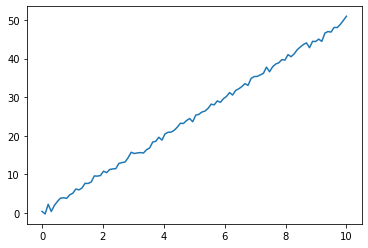

In [18]:
# create and plot simple linear relationship
x = np.linspace(0,10,100)
t = 5*x + np.random.normal(0,0.5,100)
phi = x.reshape(100,1) # simply reshape to a matrix
plt.plot(x,t)
plt.show()

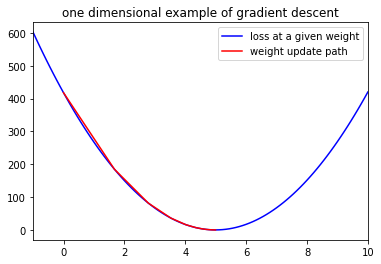

In [19]:
#Exercise: Explore role of learning rate, make sure you understand whats going on

# set hyper parameters
eta = 0.01
epochs = 10

# weights, gradients, and cost at each update (data for the red lines)
weights, gradients, costs = lr_gd(phi,t,eta,100)

# loss at a given weight (the blue parabola)
linspace_w = np.linspace(-1,10,100)
linspace_loss = [square_loss(t,x*w) for w in linspace_w]

# plot
plt.plot(linspace_w, linspace_loss,c='b',label='loss at a given weight')
plt.plot(weights,costs,c='r',label='weight update path')
plt.legend()
plt.title('one dimensional example of gradient descent')
plt.xlim([-1,10])
#plt.ylim([0,650])
plt.show()

## Explore the role of learning rate (and number of iterations)

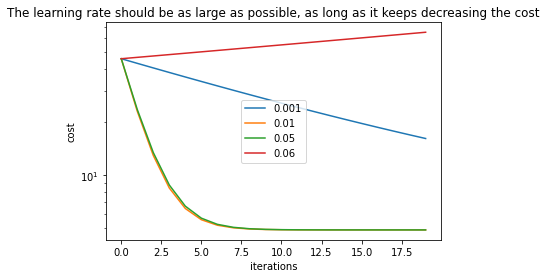

In [20]:
#Exercise: ptimize with different learning rates, make sure you understand what's going on
lr_range = [0.001, 0.01,0.05, 0.06]
cost_dict = {}
for l in lr_range:
    params, grads, costs = lr_gd(phi,t_ex, l, 20, verbose=False)
    cost_dict[l] = costs
    
# plot
plt.yscale('log') 
for l in lr_range:
    plt.plot(cost_dict[l],label=l)

plt.title('The learning rate should be as large as possible, as long as it keeps decreasing the cost')    
plt.ylabel('cost')
plt.xlabel('iterations')
plt.legend()
plt.show()

## Multi-dimensional example

Now try to estimate our original dataset (with 15 gaussian basis transformations like before), with gradient descent.

In [21]:
#Exercise: 
# * Estimate a linear regression with gradient descent on phi_ex, and t_ex
# * Get the predictions
# * Print the Cost and the R Squared

### START CODE HERE###
eta = 0.05
epochs = 100
weights, gradients, costs = lr_gd(phi_ex,t_ex,eta,epochs)
w = weights[-1,:]
y = lr_predict(phi_ex,w)

loss = square_loss(t_ex,y)
print(f'Loss with gradient descent: {loss:.2f}')
r2 = r2_score(t_ex,y)
print(f'R2 score with gradient descent: {r2:.3f}')
### END CODE HERE ###

Loss with gradient descent: 4.27
R2 score with gradient descent: 0.616


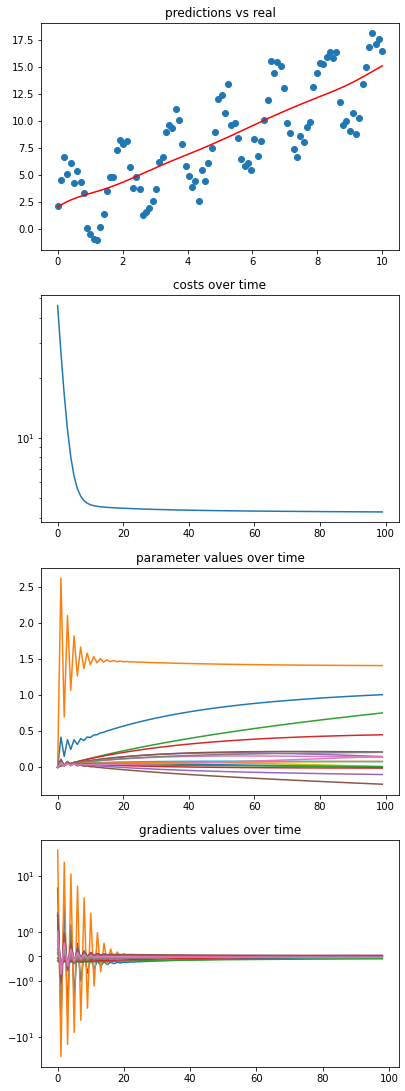

In [22]:
#Exercise: Make plots to inspect your results 
# * Real vs Predictions
# * Cost at each iteration
# * Parameter values at each iteration
# * Gradients at each iteration

### START CODE HERE ###
#plot result
fig = plt.figure(figsize=(6.4,4.8*4))
# predictions vs real
ax = fig.add_subplot(4,1,1)
ax.scatter(x_ex,t_ex)
ax.plot(x_ex,y,'r-')
ax.set_title('predictions vs real')

# costs over time 
ax = fig.add_subplot(4,1,2)
ax.plot(costs)
ax.set_title('costs over time')
ax.set_yscale('log')

# parameters over time 
ax = fig.add_subplot(4,1,3)
for i in range(weights.shape[1]):
    ax.plot(weights[:,i])
ax.set_title('parameter values over time')

# gradients over time 
ax = fig.add_subplot(4,1,4)
for i in range(weights.shape[1]):
    ax.plot(gradients[1:,i])
ax.set_title('gradients values over time')
ax.set_yscale('symlog')
### END CODE HERE ###

In [23]:
printmd('**Markdown exercise below!**','red')

<span style='color:red'>**Markdown exercise below!**</span>

**@Markdown Exercise:**

**A) Explain how learning rate affects how fast we find the optimal value.**

*@@@ START MARKDOWN HERE @@@*

The change in cost depends directly on the change in parameters, which in turn directly depends on the learning rate.

*@@@ END MARKDOWN HERE @@@*

**B) Explain how the number of iterations affects the cost**

*@@@ START MARKDOWN HERE @@@*

Each iteration changes the parameters, and therefore  the cost a little bit. If we have more iterations, then we update 
the parameter more often and therefore also the cost.

*@@@ END MARKDOWN HERE @@@*

**C) Explain why some learning rates cause thet cost to increase. Try to draw diagram the effect of a too large learning rate (on pen and paper).**

*@@@ START MARKDOWN HERE @@@*

If the learning rate is too large then it will update the parameters too much and overshoot its target so much that it will have an even larger gradient than before. For example, if a true parameter is 5, and if the current parameter is 4 with a gradient of -5, , then a learning rate of 0.8 will change the parameter to 8 (8=4-0.8x-05)...thus worsening the situation.

*@@@ END MARKDOWN HERE @@@*

# Stochastic Gradient Descent
## Intuition

We see that our gradient based method works. However, when the size of the dataset increases it will slow down and can potentially run into memory issues.

**@Markdown Exercise:**

**Explain why gradient descent slows down as the number of data points and/or features increases**

*@@@ START MARKDOWN HERE @@@*

The calculation of the gradient is a large matrix operation that will take longer as the number of observations and features increase. See the formula for the gradient we previously derived.

*@@@ END MARKDOWN HERE @@@*

## Solution

To alleviate this issue we simply calculate the gradient at each update step based on only a subset of the observations. This might be less precise, but as long as we calculate the gradient along a different subset of the data everytime it will still work out in the end.

## Create method

In [24]:
#Exercise: stochastic gradient descent based parameter estimation
def lr_sgd(phi,t,eta, batch_size, epochs, verbose=False):
    """    
    Purpose:
        Optimizer function for the stochastic gradient descent algorithm
            keep updating the parameters w for a given number of epochs based on batches
    Inputs:
        phi        (n,k) matrix, design matrix
        t          (n,) vector, target variable
        eta        double, learning rate
        batch_size integer, length of subset of data in one batch
        epochs     integer, number of epochs, that is the number of runs through the entire dataset
    Output:
        weights    (total_iters,k) matrix, weight values for each epoch
        gradients  (total_iters,k) matrix, gradient values for each epoch
        costs      (total_iters,) vector, loss values for each epoch
    """
    # intialize
    w = np.zeros(phi.shape[1])
    n = t.shape[0]
    
    ### START CODE HERE ###
    # calc iters per epoch given a batch size
    iters_per_epoch = n//batch_size
    total_iters = epochs * iters_per_epoch
    ### END CODE HERE ###
    
    # lists to return
    weights = np.zeros((total_iters,phi.shape[1]))
    gradients = np.zeros((total_iters,phi.shape[1]))
    costs = np.zeros((total_iters))
    
    for epoch in range(int(epochs)):
        ### START CODE HERE ###
        # shuffle the dataset
        shuffle_ind = np.random.permutation(n)
        phi_s = phi[shuffle_ind,:]
        t_s = t[shuffle_ind]
        
        ### END CODE HERE ###
        for i in range(iters_per_epoch):
            
            ### START CODE HERE ###
            # go through the training loop
            # ensure calculations are on the correct batch of the dataset
            # ensure the returned costs are on the entire dataset
            
            idx = epoch * iters_per_epoch + i
            
            phi_b = phi_s[i*batch_size:(i+1)*batch_size,:]
            t_b = t_s[i*batch_size:(i+1)*batch_size]
            
            
            weights[idx,:] = w
            y_b = lr_predict(phi_b, w)
            y = lr_predict(phi, w)

            costs[idx] = square_loss(t,y)
            
            dEdw = lr_gradient(phi_b,t_b,y_b)
            gradients[idx,:] = dEdw

            w = w - eta*dEdw
        
            ### END CODE HERE ###
            
        # print
        if verbose:
            r2 = r2_score(t,y)
            print(f'epoch: {epoch}: E:{E:.2f}, R2:{r2:.2f}')    
            
    
    return weights, gradients, costs


## Example

In [25]:
# Exercise: 
# * use your SGD function to estimate the our dataset (phi_ex,t_ex) 
# * report the costs and r^2
# * does it make sense? Look at the next question for help
eta = 0.005
epochs = 100
### START CODE HERE ###
weights, gradients, costs = lr_sgd(phi_ex,t_ex, eta, 10, epochs, verbose=False)

# get preds
w = weights[-1,:]
y = lr_predict(phi_ex, w)

# print scores
loss = square_loss(t_ex,y)
print(f'Loss with gradient descent: {loss:.2f}')
r2 = r2_score(t_ex,y)
print(f'R2 score with gradient descent: {r2:.3f}')
### END CODE HERE ###


Loss with gradient descent: 4.27
R2 score with gradient descent: 0.616


Text(0.5, 1.0, 'gradients values over time')

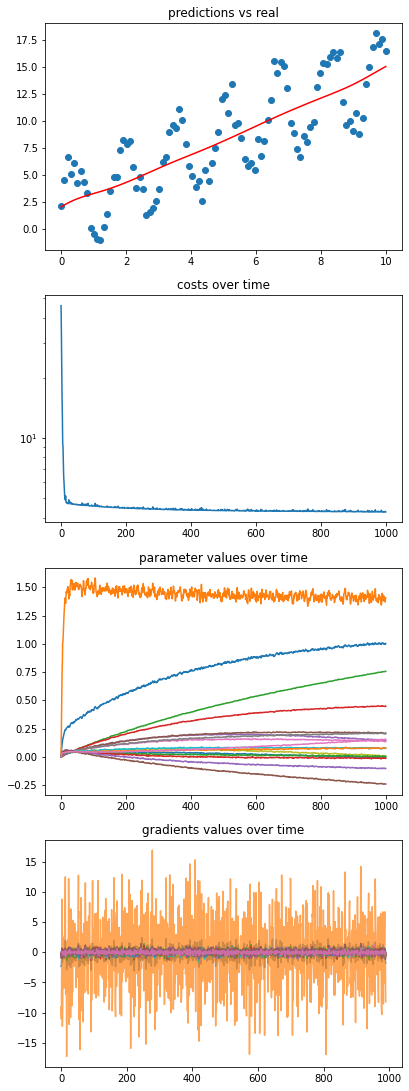

In [26]:
#Exercise: Make plots to inspect your results 
# * Real vs Predictions
# * Cost at each iteration
# * Parameter values at each iteration
# * Gradients at each iteration

### START CODE HERE ###
#plot result
fig = plt.figure(figsize=(6.4,4.8*4))
# predictions vs real
ax = fig.add_subplot(4,1,1)
ax.scatter(x_ex,t_ex)
ax.plot(x_ex,y,'r-')
ax.set_title('predictions vs real')

# costs over time 
ax = fig.add_subplot(4,1,2)
ax.plot(costs)
ax.set_title('costs over time')
ax.set_yscale('log')

# parameters over time 
ax = fig.add_subplot(4,1,3)
for i in range(weights.shape[1]):
    ax.plot(weights[:,i])
ax.set_title('parameter values over time')

# gradients over time 
ax = fig.add_subplot(4,1,4)
for i in range(weights.shape[1]):
    ax.plot(gradients[10:,i],alpha=0.7)
ax.set_title('gradients values over time')
#ax.set_yscale('symlog')
### END CODE HERE ###

## Explore the role of batch size

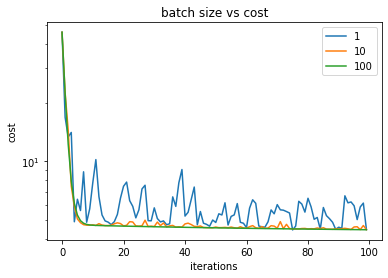

In [27]:
# Exercise: explore the role of batch sizes, make sure you understand what it does
bs_range =  [1, 10, 100]
epochs = 100

# calc
cost_dict = {}
iterations = 100
n = t_ex.shape[0]
for bs in bs_range:
    epochs = iterations/(n/bs)
    params, grads, costs = lr_sgd(phi_ex,t_ex, 0.01, int(bs), int(epochs), verbose=False)
    cost_dict[bs] = costs
    
# plot
for bs in bs_range:
    plt.plot(cost_dict[bs],label=bs)

plt.title('batch size vs cost')    
plt.yscale('log') 
plt.ylabel('cost')
plt.xlabel('iterations')
plt.legend()
plt.show()

In [28]:
printmd('**Markdown exercise below!**','red')

<span style='color:red'>**Markdown exercise below!**</span>

**@Markdown Exercise:**

**Explain how the batch size affects the volatility of changes in costs per iteration. You should be able to explain this intuitively and be able to prove it mathematically.**

*@@@ START MARKDOWN HERE @@@*

Intuitively: if the batch size is small, then its suggestion to change the parameters will be focused on improving the fit of only that small batch, not keeping in mind how that affects the fit of the entire dataset. Therefore, changing the parameters to better fit a smalller batch can have unintended consequences of the fit of the parameters towards the rest of the dataset.

Mathematically: the changes in the cost function become more volatile (i.e. standard deviation increases), because it is a function of the gradient ($\frac{\partial E}{\partial \mathbf{w}}$). The gradient itself becomes more volatile as the batch size decreases, because it is a function of both the squared error and of the features itself. Each of those standard deviations increase as the batch size decreases as per the definition of the standard deviation.

*@@@ END MARKDOWN HERE @@@*

**Explain how batch size affects the optimal learning rate.**

*@@@ START MARKDOWN HERE @@@*

For smaller (larger) batch sizes, a smaller (larger) learning rate should be used. The reasons is that for smaller (larger) batch sizes we are less (more) sure that the gradient is actually pointing in the right direction to reduce the cost for the entire population

*@@@ END MARKDOWN HERE @@@*

# Conclusion

## What did we learn today

* Gaussian transformation based feature engineering
* Inverse based method works best, but it is limited by:
    * Memory to actually calculate the inverse
    * Linear model with a one and only one minimum
* Gradient descent is a stepwise method:
    * It suffers less from the curse of dimensionality, althought the number of observations can still be problematic
    * It can even work when there is no unique global minimum
    * It introduces new hyperparameters that need to be tuned: learning rate, and epochs
* Stochastic gradient descent solves the dimensionality issue of gradient descent:
    * By only taking a subset at each update step we are not directly impacted by the size of the dataset
    * It introduces another hyperparameter: batch size
    * Learning can take quite a while

## What will we learn in the future

* How to improve stochastic gradient descent's learning speed
* How to apply regularization to stochastic gradient descent
* How to use stochastic gradient descent for classification
* How to use stochastic gradient descent for nonlinear models (neural networks)

## Homework

* Complete the problems in this notebook
* Read Chapter 3 of Bishop
* Prepare some questions for the lecture